In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft,dct
import librosa
from scipy import signal
import librosa.display
import soundfile as sf
import sounddevice as sd
from icecream import ic

### 1. Constant-Q spectrogram and chromagram (1 point)

#### a) Load 'brahms_hungarian_dance_5_short.wav'

In [2]:
audio_signal, sample_rate = librosa.load('brahms_hungarian_dance_5_short.wav')
print(f"Audio signal: {audio_signal}")
print(f"Sampling rate: {sample_rate}")

Audio signal: [ 0.          0.          0.         ... -0.12026978 -0.13052368
 -0.1359253 ]
Sampling rate: 22050


#### b) Calculate the spectrogram

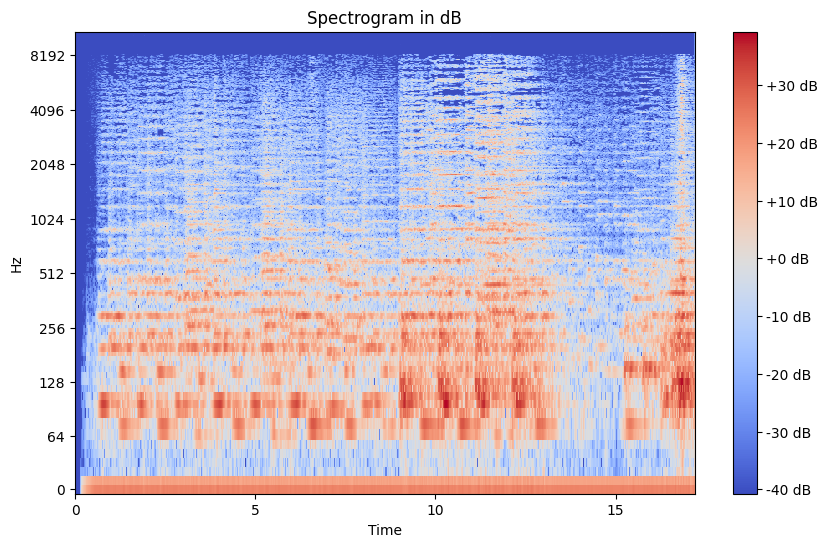

In [3]:
spectrogram = (librosa.core.stft(audio_signal))
spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))

plt.figure(figsize = (10, 6))
librosa.display.specshow(spectrogram_db, sr = sample_rate, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title('Spectrogram in dB')
plt.show()

#### c) Calculate the constant-Q spectrogram

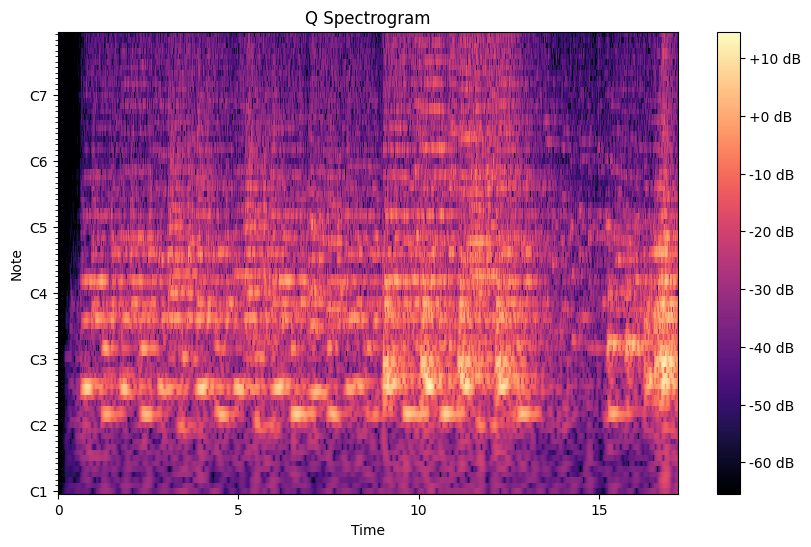

In [4]:
constant_Q_spectrogram = librosa.core.cqt(audio_signal, sr = sample_rate)
constant_Q_spectrogram_db = librosa.amplitude_to_db(np.abs(constant_Q_spectrogram))

plt.figure(figsize = (10, 6))
librosa.display.specshow(constant_Q_spectrogram_db, sr = sample_rate, x_axis = 'time', y_axis = 'cqt_note')
plt.colorbar(format = '%+2.0f dB')
plt.title('Q Spectrogram')
plt.show()

#### d) Calculate the chromagram

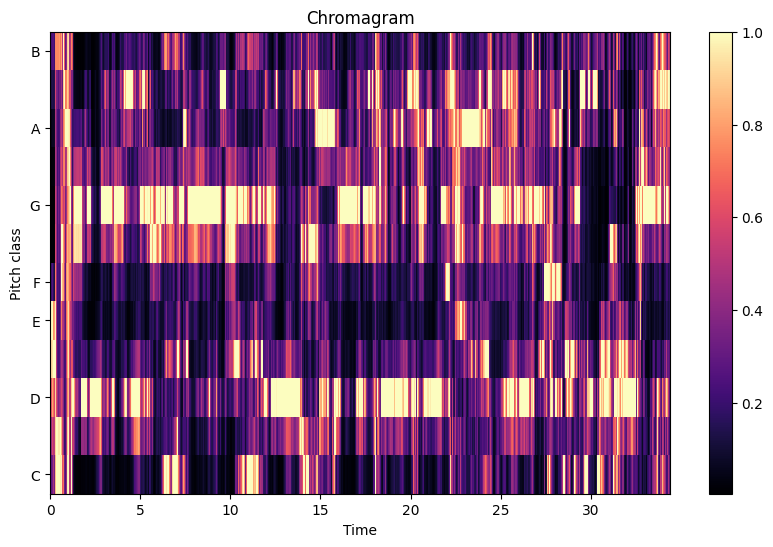

In [5]:
chromagram = librosa.feature.chroma_stft(y = audio_signal, sr = sample_rate, hop_length= 256)

plt.figure(figsize = (10, 6))
librosa.display.specshow(chromagram, sr = sample_rate, x_axis = 'time', y_axis = 'chroma')
plt.colorbar()
plt.title('Chromagram')
plt.show()

#### e) Plot, observe and report differences.

Differences are very notable: 
- For the spectrogram, this represents the signal's frequency content over time, and is more useful for a general purpose time-frequency analysis.
- For analysing more "musical" signals, cq-spectrogram is more useful, as it gives a figure similar to the first spectrogram, but highlighting the pitch/note that is being played. As this graph is still continuous, more details like the instrument tone or harmonics/fundamentals being played can be noticed.
- The chromagram can be used for a better "pitch" focused analysis, but as the graph is discrete, some details from the cq-spectrogram are lost. Nevertheless, the notes being played are very distinguishable in this graph.

### 2. Onset detection (1 point)

#### a.1) load the audio file

In [21]:
audio_signal_2, sample_rate_2 = librosa.load('conga_groove.wav')

print(f"Audio signal: {audio_signal_2}")
print(f"Sampling rate: {sample_rate_2}")

Audio signal: [-0.00128174  0.00137329 -0.00308228 ... -0.05706787 -0.07006836
 -0.05072021]
Sampling rate: 22050


#### a.2) Compute spectral novelty function

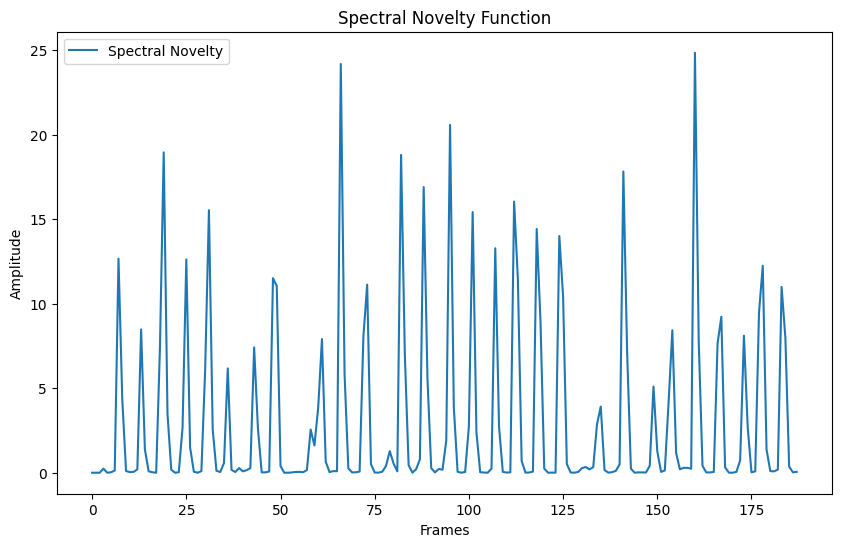

In [22]:
onset_amp = librosa.onset.onset_strength(y=audio_signal_2, sr=sample_rate_2)

plt.figure(figsize=(10, 6))
plt.plot(onset_amp, label='Spectral Novelty')
plt.xlabel('Frames')
plt.ylabel('Amplitude')
plt.title('Spectral Novelty Function')
plt.legend()
plt.show()

#### a.3) Pick peaks

In [23]:
onset_frames = librosa.util.peak_pick(onset_amp, 
                                      pre_max=8, 
                                      post_max=8, 
                                      pre_avg=30, 
                                      post_avg=30, 
                                      delta=0.5, wait=5)

print(f"Onset frames: {onset_frames}")

Onset frames: [  7  19  31  48  66  82  95 112 141 160 178]


#### a.4) Convert frame indexes into time indexes

In [24]:
onset_time = librosa.frames_to_time(onset_frames, sr=sample_rate_2)
print(f"Onset time: {onset_time}")

Onset time: [0.16253968 0.44117914 0.71981859 1.11455782 1.53251701 1.90403628
 2.20589569 2.60063492 3.27401361 3.71519274 4.13315193]


#### a.5) Plot onsets on top of the time domain signal. Report observations.

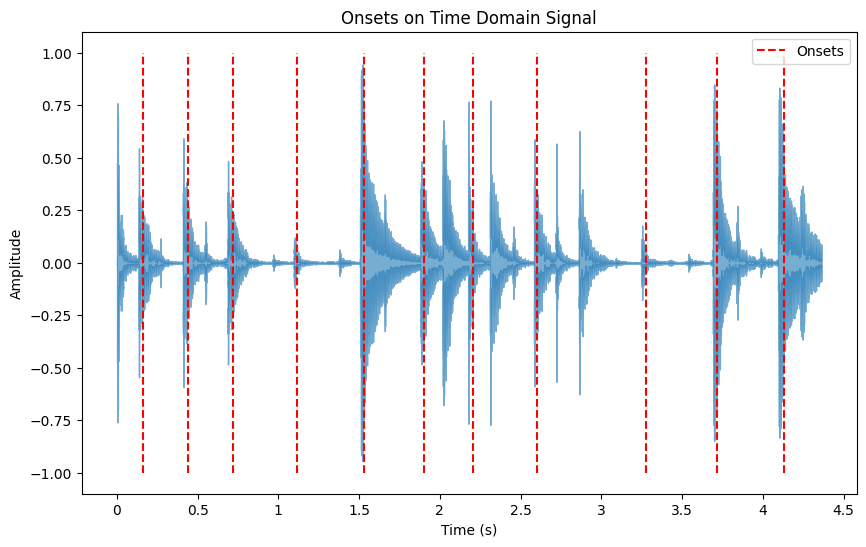

In [25]:
plt.figure(figsize=(10, 6))

librosa.display.waveshow(audio_signal_2, sr=sample_rate_2, alpha=0.6)
plt.vlines(onset_time, -1, 1, 
           color='r', linestyle='--', label='Onsets')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Onsets on Time Domain Signal')
plt.legend()
plt.show()

#### a.6) Plot onsets on top of the spectrogram. Report observations.

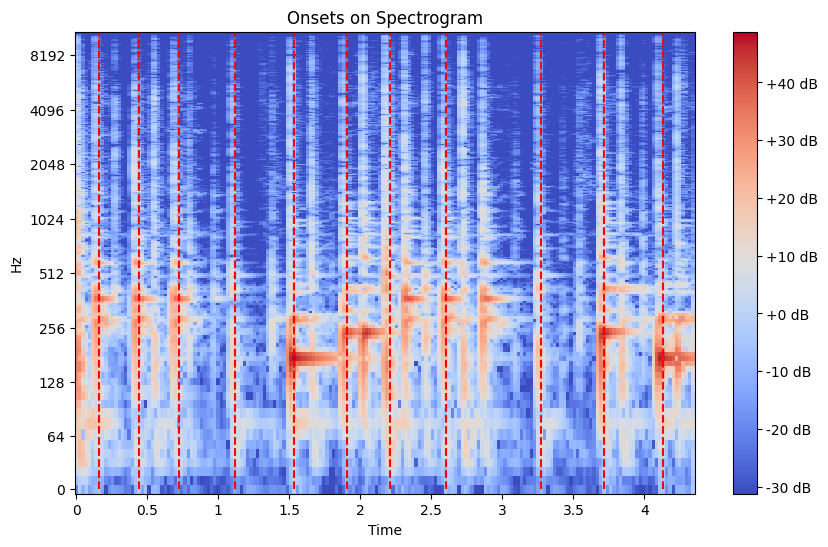

In [27]:
plt.figure(figsize=(10, 6))


spectrogram_db_2 = librosa.amplitude_to_db(np.abs(librosa.core.stft(audio_signal_2)))
librosa.display.specshow(spectrogram_db_2, sr=sample_rate_2, x_axis='time', y_axis='log')

plt.vlines(onset_time, 0, sample_rate_2/2, color='r', linestyle='--', label='Onsets')

plt.colorbar(format='%+2.0f dB')
plt.title('Onsets on Spectrogram')
plt.show()

### Add clicks to the onsets

#### b.1) Create a signal consisting of clicks at specified locations.

In [28]:
signal_length = len(audio_signal_2)
click_signal_2 = librosa.clicks(frames=onset_frames, sr=sample_rate_2, length = signal_length)

#### b.2) Add the two signals together.

In [29]:
samplewise_sigma_signal = audio_signal_2 + click_signal_2

#Print for testing
ic(samplewise_sigma_signal)
print(len(samplewise_sigma_signal))

ic| samplewise_sigma_signal: array([-0.00128174,  0.00137329, -0.00308228, ..., -0.05706787,
                                    -0.07006836, -0.05072021], dtype=float32)


96213


#### b.2) Play it.

In [30]:
sd.play(samplewise_sigma_signal, sample_rate_2)
sd.wait()
sd.stop()

#### b.3) Stack them to create stereo signal.

In [33]:
stack_sigma_signal = np.vstack([audio_signal_2, click_signal_2]).T

#Print for testing
ic(stack_sigma_signal)
print(len(stack_sigma_signal))

ic| stack_sigma_signal: array([[-0.00128174

,  0.        ],
                               [ 0.00137329,  0.        ],
                               [-0.00308228,  0.        ],
                               ...,
                               [-0.05706787,  0.        ],
                               [-0.07006836,  0.        ],
                               [-0.05072021,  0.        ]], dtype=float32)


96213


#### b.3) Play it.

In [34]:
sd.play(stack_sigma_signal, sample_rate_2)
sd.wait()
sd.stop()

After testing all given audios, the detection of peaks with librosa peak.pick() is acurate, but it sometimes misses 1 or 2 peaks. Also there is a little delay after the picks, specially in the percussion audios, maybe because the attack phases in these are way faster and agressive than in the instrumental audio.

### Bonus problem: Implement your own spectral novelty function